In [13]:
import pandas as pd
import numpy as np
import math

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score,explained_variance_score
import sklearn.model_selection

from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split

from math import sqrt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import env
import wrangle
import viz
import split_and_scale

# Step 1. Wrangle the data

- The get_df function returns a clean dataframe by performing the following tasks:
> 1. A SQL query of the Zillow database produces results that include only single family homes purchased between May and June 2017. 
> 2. Zeros and null values were filtered out and removed. 
> 3. Any non essential columns were dropped
> 4. A new column was added designating the county where each home is located. All homes in the data set are located in the state of California
> 5. A calculated field 'tax_rate' was also added


In [2]:
df = wrangle.get_df()
df

,square_feet,taxes,home_value,bedroom_count,bathroom_count,County,tax_rate
0,1458.0,2319.90,136104.0,3.0,2.0,Los Angeles,0.017045
1,1421.0,543.69,35606.0,2.0,1.0,Los Angeles,0.015270
2,2541.0,9819.72,880456.0,4.0,3.0,Orange,0.011153
3,1650.0,7673.19,614000.0,3.0,2.0,Los Angeles,0.012497
4,693.0,3267.47,274237.0,2.0,1.0,Los Angeles,0.011915
...,...,...,...,...,...,...,...
14985,2526.0,5718.72,458903.0,5.0,3.0,Orange,0.012462
14986,2735.0,1465.88,115387.0,5.0,3.0,Orange,0.012704
14987,1536.0,3519.78,297097.0,3.0,2.0,Los Angeles,0.011847
14988,2655.0,8065.50,746963.0,5.0,3.0,Orange,0.010798


- To double check that there are no zeros or null values before we start working with the data, run the following asserts and NA count

In [3]:
assert (df['square_feet'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"
assert (df['taxes'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"
assert (df['home_value'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"
assert (df['bedroom_count'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"
assert (df['bathroom_count'] == 0).sum() < 1 , "There are zeros in this column. Handle them before proceeding"

In [4]:
df.isnull().sum()

square_feet       0
taxes             0
home_value        0
bedroom_count     0
bathroom_count    0
County            0
tax_rate          0
dtype: int64

- Brief overview of the shape of the data and data types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14989 entries, 0 to 14989
Data columns (total 7 columns):
square_feet       14989 non-null float64
taxes             14989 non-null float64
home_value        14989 non-null float64
bedroom_count     14989 non-null float64
bathroom_count    14989 non-null float64
County            14989 non-null object
tax_rate          14989 non-null float64
dtypes: float64(6), object(1)
memory usage: 936.8+ KB


# Step 2: Explore what we have

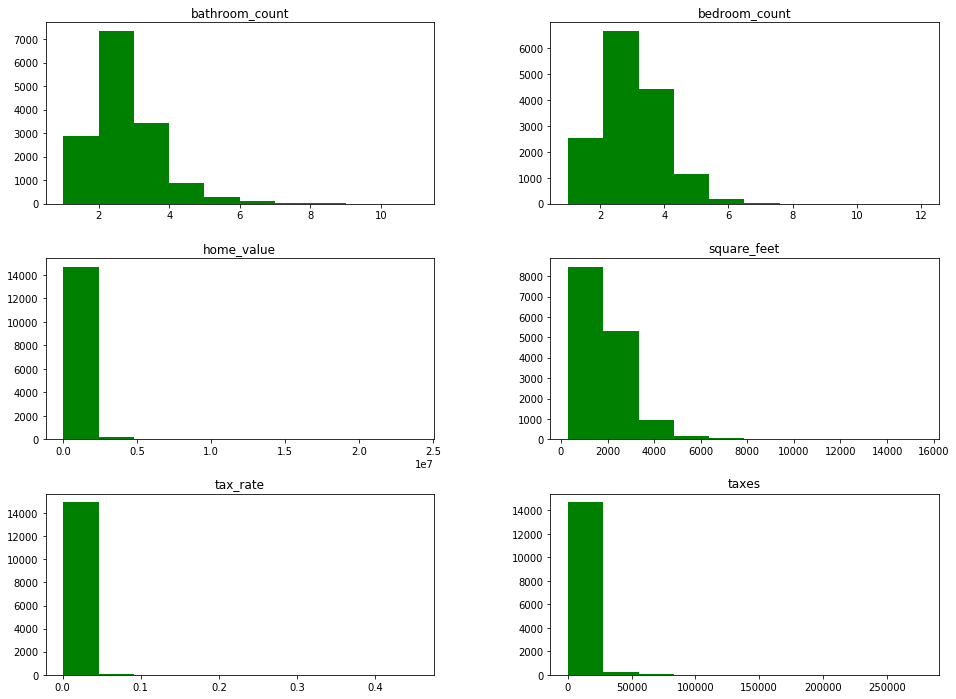

In [6]:
df.hist(grid=False, figsize=(16,12), color='green')
plt.show()

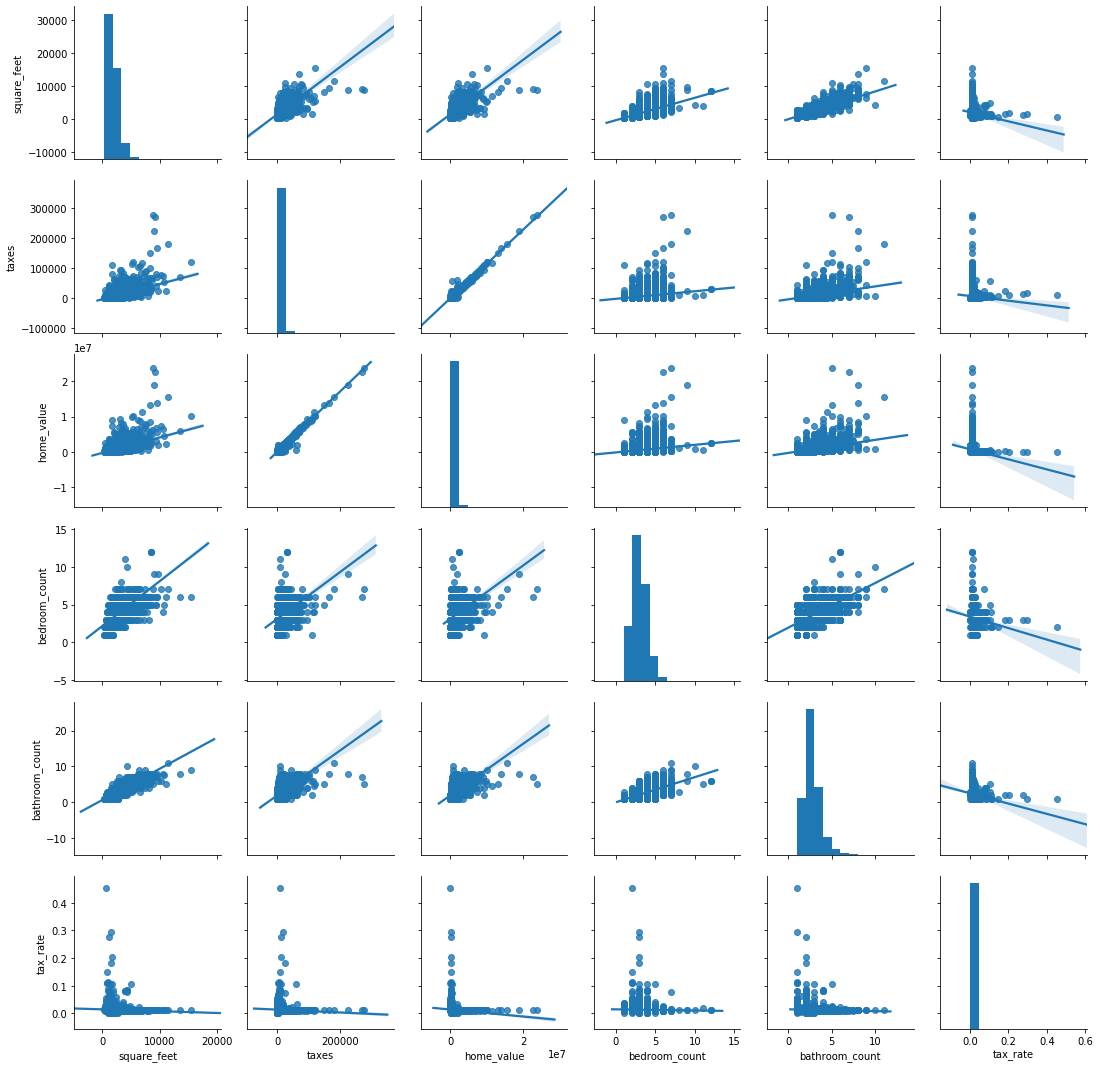

In [7]:
sns.pairplot(df, kind="reg")
plt.show()

In [8]:
df.corr(method ='pearson') 

,square_feet,taxes,home_value,bedroom_count,bathroom_count,tax_rate
square_feet,1.000000,0.603672,0.602110,0.634737,0.855666,-0.095110
taxes,0.603672,1.000000,0.989347,0.279657,0.519436,-0.063567
home_value,0.602110,0.989347,1.000000,0.276025,0.517097,-0.134599
bedroom_count,0.634737,0.279657,0.276025,1.000000,0.643954,-0.056054
bathroom_count,0.855666,0.519436,0.517097,0.643954,1.000000,-0.097136
tax_rate,-0.095110,-0.063567,-0.134599,-0.056054,-0.097136,1.000000


- The Pearson's R test is used to compare two continuous variables and see if they are linearly correlated, and the strength of the correlation.
- Right off the bat I see some fairly stong correlations between our target variable (home_value) and square_feet as well as bathroom_count. 
- I also note that there is some correlation between our independent variable. I will consider running an RFE later to determine weight of this correlation when selecting the proper variables for modeling

#### Let's answer the question about distribution of tax rates by county

In [9]:
df.County.value_counts()

Los Angeles    9604
Orange         4094
Ventura        1291
Name: County, dtype: int64

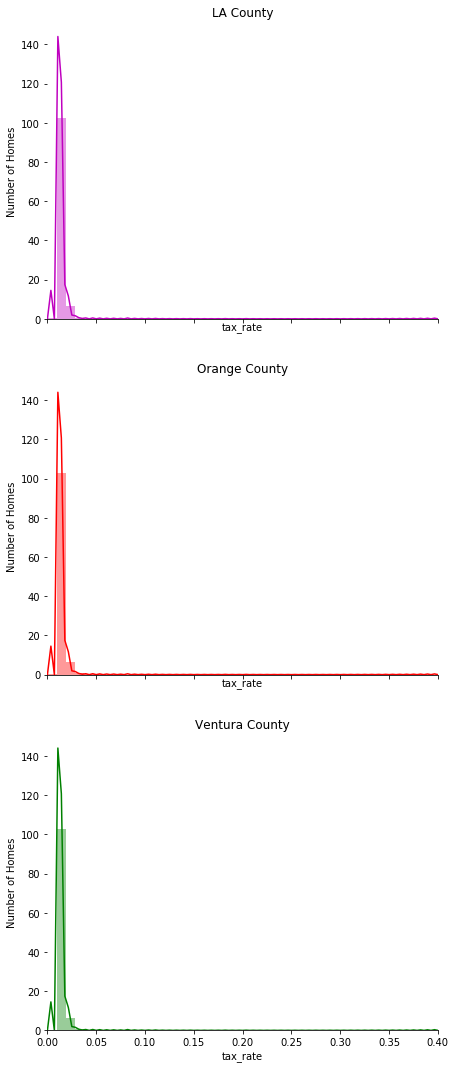

In [10]:
plot = viz.plot_distributions()

In [11]:
county_mean_tax_rate = pd.DataFrame(round(df.groupby("County").tax_rate.mean(),4))
county_mean_tax_rate.columns = ['Mean Tax Rate']

In [12]:
county_mean_tax_rate

,Mean Tax Rate
County,
Los Angeles,0.0142
Orange,0.0121
Ventura,0.0121


# Step 3: Modeling

### Start with splitting and scaling the data

- I will use the min/max scaler here
- Our target variable is the home_value
- We were told to use bedroom and bathroom count along with square root. I'll run an RFE to determine if those three are the best features to use given that they showed some correlation with eachother

In [17]:
train, test = split_and_scale.split_data(df)

- Now that the data is split into the train and test variables, let's take a look at each variable

In [18]:
train.head()

,square_feet,taxes,home_value,bedroom_count,bathroom_count,County,tax_rate
1860,1938.0,10310.56,208558.0,4.0,2.0,Los Angeles,0.049437
442,2891.0,9189.99,757831.0,4.0,4.0,Los Angeles,0.012127
14935,1574.0,5143.48,446004.0,3.0,2.5,Orange,0.011532
5221,2304.0,7069.39,613428.0,4.0,3.0,Los Angeles,0.011524
3663,998.0,830.35,44679.0,2.0,1.0,Los Angeles,0.018585


In [21]:
train.shape

(11241, 7)

In [19]:
test.head()

,square_feet,taxes,home_value,bedroom_count,bathroom_count,County,tax_rate
3144,2774.0,4309.47,286000.0,4.0,3.0,Los Angeles,0.015068
6315,2142.0,8822.75,750000.0,4.0,3.0,Los Angeles,0.011764
2442,2150.0,4161.99,279000.0,3.0,2.0,Los Angeles,0.014918
4483,3359.0,6895.67,559002.0,4.0,4.0,Los Angeles,0.012336
9536,2743.0,12796.32,1177495.0,4.0,3.5,Orange,0.010867


In [22]:
test.shape

(3748, 7)

- Split looks good!

#### Now that the data is split apporpriately, let's define our target and dependent variables for both the train and test data

In [23]:
X_train = train[['square_feet', 'bedroom_count', 'bathroom_count']]
X_test = test[['square_feet', 'bedroom_count', 'bathroom_count']]
y_train = train[['home_value']]
y_test = test[['home_value']]

- Next step is to create a dataframe that will hold the actual home values as well as all the predictions from the models we will be creating. 
> I'll make a copy of the data so as not to mutate the original dataset